# PINNS Project

In [2]:
import torch
import torch.nn as nn
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from contextlib import contextmanager
from pathlib import Path
import subprocess
from functools import partial


# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

np.random.seed(1234)

print("Using device: ", device)

Using device:  cuda


## Studying the Kuramoto-Sivashinsky equation following this PDE:

#### $$u_t + u_{xxxx} + uu_{x} + u_{xx} = 0$$

### Loading the data

In [3]:
data = scipy.io.loadmat("KS.mat")

t = torch.tensor(data["tt"].flatten()[:], dtype=torch.float32)
x = torch.tensor(data["x"].flatten()[:], dtype=torch.float32)
Exact = torch.tensor(data["uu"].T, dtype=torch.float32)
extent = [t.min(), t.max(), x.min(), x.max()]

print("t.shape", t.shape)
print("x.shape", x.shape)
print("Exact.shape", Exact.shape)

t.shape torch.Size([201])
x.shape torch.Size([513])
Exact.shape torch.Size([201, 513])


In [4]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 19 14:35:03 2017',
 '__version__': '1.0',
 '__globals__': [],
 'tt': array([[0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
         0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
         0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
         0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
         0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
         0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
         0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
         0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
         0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
         0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
         0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
         0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 

# Plot the evolution of the solution over time

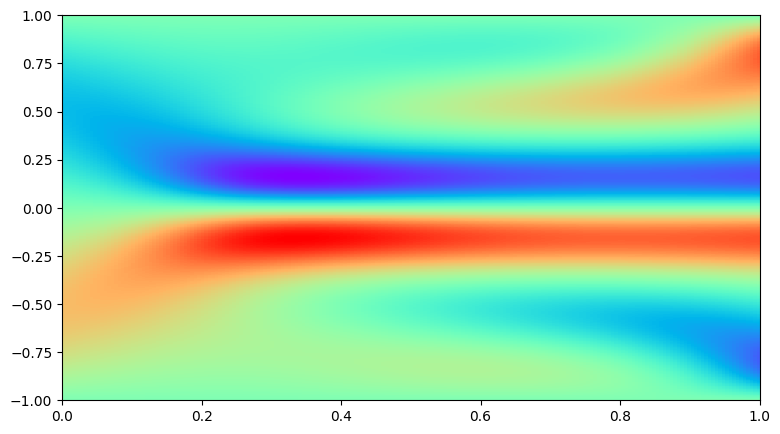

In [5]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Exact.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=extent,
    origin="lower",
    aspect="auto",
)

# Learning the solution with physics-informed contraints

# Collecting the labeled and unlabeled data

In [7]:
# Creates a grid from x and t, of shape (time x position)
T, X = torch.meshgrid(t, x, indexing="ij")

assert len(X) == len(t)
assert Exact.shape == T.shape, f"Exact.shape={Exact.shape}, T.shape={T.shape}"

X_star = torch.hstack((X.flatten().view(-1, 1), T.flatten().view(-1, 1)))

u_star = Exact.flatten()

print("X_star.shape", X_star.shape)

X_star.shape torch.Size([103113, 2])


In [9]:
# Label points

N_u = 100

x_train = torch.zeros(N_u, 1)
t_train = torch.zeros(N_u, 1)
u_train = torch.zeros(N_u, 1)

print(u_train.shape)

available_t_xmin = torch.arange(t.size(0) - 1)
available_t_xmax = torch.arange(t.size(0) - 1)
available_x_t0 = torch.arange(x.size(0) - 1)
choices = torch.linspace(start=0, end=2, steps=3, dtype=torch.int)

for i in range(N_u):
    choice = np.random.permutation(choices)[0]
    if choice == 0:
        # case (xmin,t)
        x_train[i] = x[0]
        choice_t_xmin = np.random.choice(available_t_xmin)
        np.delete(available_t_xmin, choice_t_xmin)
        t_train[i] = t[choice_t_xmin]
        u_train[i] = Exact[choice_t_xmin, 0]
    elif choice == 1:
        x_train[i] = x[-1]
        choice_t_xmax = np.random.choice(available_t_xmax)
        np.delete(available_t_xmax, choice_t_xmax)
        t_train[i] = t[choice_t_xmax]
        u_train[i] = Exact[choice_t_xmax, -1]
    else:
        # case (x,0)
        t_train[i] = t[0]
        choice_x_t0 = np.random.choice(available_x_t0)
        np.delete(available_x_t0, choice_x_t0)
        x_train[i] = x[choice_x_t0]
        u_train[i] = Exact[0, choice_x_t0]


# Some checks...

assert x_train.shape == (N_u, 1), f"{x_train.shape} != {(N_u, 1)}"
assert t_train.shape == (N_u, 1), f"{t_train.shape} != {(N_u, 1)}"
assert u_train.shape == (N_u, 1), f"{u_train.shape} != {(N_u, 1)}"
assert (
    (t_train == 0) | (x_train == float(x.min())) | (x_train == float(x.max()))
).all(), "Some points do not belong to boundary"

torch.Size([100, 1])


In [10]:
# Unlabel points

N_f = 10000

t_idx = torch.arange(t.size(0) - 1)
x_idx = torch.arange(x.size(0) - 1)
x_train_f = x[np.random.choice(x_idx, N_f)].unsqueeze(-1)
t_train_f = t[np.random.choice(t_idx, N_f)].unsqueeze(-1)


# Some checks...

assert x_train_f.shape == (N_f, 1), f"{x_train_f.shape} != {(N_f, 1)}"
assert t_train_f.shape == (N_f, 1), f"{t_train_f.shape} != {(N_f, 1)}"
assert ((x_train_f >= x.min()) & (x_train_f <= x.max())).all()
assert ((t_train_f >= t.min()) & (t_train_f <= t.max())).all()

# Adds boundary points to the unsupervised data set
x_train_f = torch.vstack((x_train_f, x_train))
t_train_f = torch.vstack((t_train_f, t_train))

In [11]:
def prepare(*tensors):
    return (torch.Tensor(t).float().to(device) for t in tensors)


# Supervised data
x_train, t_train, u_train = prepare(x_train, t_train, u_train)

# Unsupervised data
x_train_f, t_train_f = prepare(x_train_f, t_train_f)

# All data points (for plots)
x_star, t_star = prepare(*X_star.split((1, 1), dim=1))

## Plotting the selected labeled boundary and initial points.

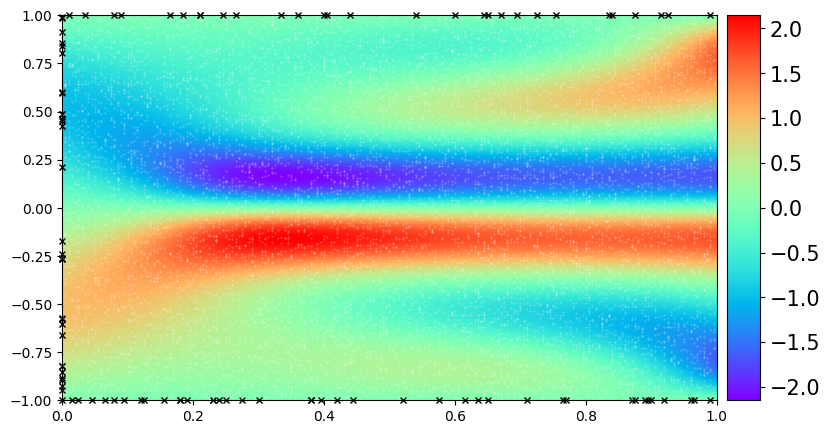

In [12]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(
    Exact.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)

# h = ax.imshow(Exact.T, cmap='rainbow', origin='lower', aspect='auto') # Exact.T size (256,100), u(x,t) avec x[0] = -1
# plt.imshow(Exact.T[::-1,:], cmap='rainbow') # Pour avoir x = -1 en bas

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train.cpu(),
    x_train.cpu(),
    "kx",
    label="Data (%d points)" % (u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

ax.plot(
    t_train_f.cpu(),
    x_train_f.cpu(),
    "wx",
    markersize=1,  # marker size doubled
    clip_on=False,
    alpha=0.2,
)

plt.show()

# The neural net for $f_{\theta}$

In [40]:
class DNN(torch.nn.Module):
    # À compléter...
    def __init__(self, depth=8, input_size=2, hidden_size=20, output_size=1):
        """
        input of size N_u x 2  = N_u x (x,t) dimensions
        """
        super().__init__()
        self.depth = depth
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        layers = [("input", nn.Linear(input_size, hidden_size))]

        layers.append(("activation input", nn.Tanh()))
        for i in range(depth):
            layers.append(("hidden %d" % i, nn.Linear(hidden_size, hidden_size)))
            layers.append(("activation %d" % i, nn.Tanh()))
        layers.append(("output", nn.Linear(hidden_size, output_size)))

        dictLayers = OrderedDict(layers)
        self.seq = nn.Sequential(dictLayers)

    def forward(self, x, t):
        X_u_train = torch.cat((x, t), dim=-1)
        return self.seq(X_u_train)

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u = self(x, t)
            u = u.detach().cpu().numpy()
            return u


dnn = DNN()


dnn.to(device)
assert dnn(x_train[:5], t_train[:5]).shape == (
    5,
    1,
), f"{dnn(x_train[5:], t_train[5:]).shape}"

In [41]:
dnn

DNN(
  (seq): Sequential(
    (input): Linear(in_features=2, out_features=20, bias=True)
    (activation input): Tanh()
    (hidden 0): Linear(in_features=20, out_features=20, bias=True)
    (activation 0): Tanh()
    (hidden 1): Linear(in_features=20, out_features=20, bias=True)
    (activation 1): Tanh()
    (hidden 2): Linear(in_features=20, out_features=20, bias=True)
    (activation 2): Tanh()
    (hidden 3): Linear(in_features=20, out_features=20, bias=True)
    (activation 3): Tanh()
    (hidden 4): Linear(in_features=20, out_features=20, bias=True)
    (activation 4): Tanh()
    (hidden 5): Linear(in_features=20, out_features=20, bias=True)
    (activation 5): Tanh()
    (hidden 6): Linear(in_features=20, out_features=20, bias=True)
    (activation 6): Tanh()
    (hidden 7): Linear(in_features=20, out_features=20, bias=True)
    (activation 7): Tanh()
    (output): Linear(in_features=20, out_features=1, bias=True)
  )
)

## Code of the PhysicsInformedNN

The code will predict the function $f_{\theta}$(x, t) and $h(f_{\theta}(x, t))$, with :

$$ h(f_{\theta}(x,t)) = \frac{\partial f_{\theta}(x,t) }{\partial t} + f_{\theta}(x,t) \frac{\partial f_{\theta}(x,t)}{x} + \frac{\partial^2 f_{\theta}(x,t)}{x^2}+ \frac{\partial^4 f_{\theta}(x,t)}{x^4}$$


In [42]:
class PhysicsInformedNN(nn.Module):
    def __init__(self, dnn: DNN):
        super().__init__()
        self.dnn = dnn

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x.requires_grad_(True)
        t.requires_grad_(True)

        u = self.dnn(x, t)

        df_dx = torch.autograd.grad(
            u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True
        )[0]
        df2_dx2 = torch.autograd.grad(
            df_dx,
            x,
            grad_outputs=torch.ones_like(df_dx),
            retain_graph=True,
            create_graph=True,
        )[0]
        df_dt = torch.autograd.grad(
            u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True
        )[0]

        df3_dx3 = torch.autograd.grad(
            df2_dx2,
            x,
            grad_outputs=torch.ones_like(df2_dx2),
            retain_graph=True,
            create_graph=True,
        )[0]

        df4_dx4 = torch.autograd.grad(
            df3_dx3,
            x,
            grad_outputs=torch.ones_like(df3_dx3),
            retain_graph=True,
            create_graph=True,
        )[0]

        h = df_dt + df4_dx4 + df2_dx2 + 1 / 2 * (df_dx**2)
        return u, h

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u, f = self(x, t)
            u = u.detach().cpu().numpy()
            f = f.detach().cpu().numpy()
            return u, f


model = PhysicsInformedNN(dnn).to(device)

u, f = model(x_train[:5], t_train[:5])
assert u.shape == (5, 1), f"{u.shape}"
assert f.shape == (5, 1), f"{f.shape}"

## Calculating the loss function

In [43]:
import torch.nn.functional as F


def pinns_loss(
    u_pred: torch.Tensor,
    u_target: torch.Tensor,
    f_pred: torch.Tensor,
    lambda_u: float = 1.0,
    lambda_f: float = 1.0,
):
    loss_u = F.mse_loss(u_pred, u_target)

    f_target = torch.zeros_like(f_pred).to(device)
    loss_f = F.mse_loss(f_pred, f_target)

    loss = lambda_u * loss_u + lambda_f * loss_f

    return loss, loss_u, loss_f

In [35]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

dnn = DNN().to(device)
model = PhysicsInformedNN(dnn).to(device)
optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=1e-3,
    max_iter=500,
    max_eval=500,
    history_size=50,
    line_search_fn="strong_wolfe",
)

epoch = 70
ti = tqdm(range(epoch))
for i in ti:

    def loss_closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        u_pred = dnn(x_train, t_train)

        f_theta, f_pred = model(x_train_f, t_train_f)
        loss, loss_u, loss_f = pinns_loss(u_pred, u_train, f_pred)
        ti.set_description(f"loss: {loss}")
        writer.add_scalar("loss", loss, i)

        if loss.requires_grad:
            loss.backward()

        return loss

    optimizer.step(loss_closure)

loss: 0.12179826945066452: 100%|██████████| 70/70 [00:54<00:00,  1.27it/s]


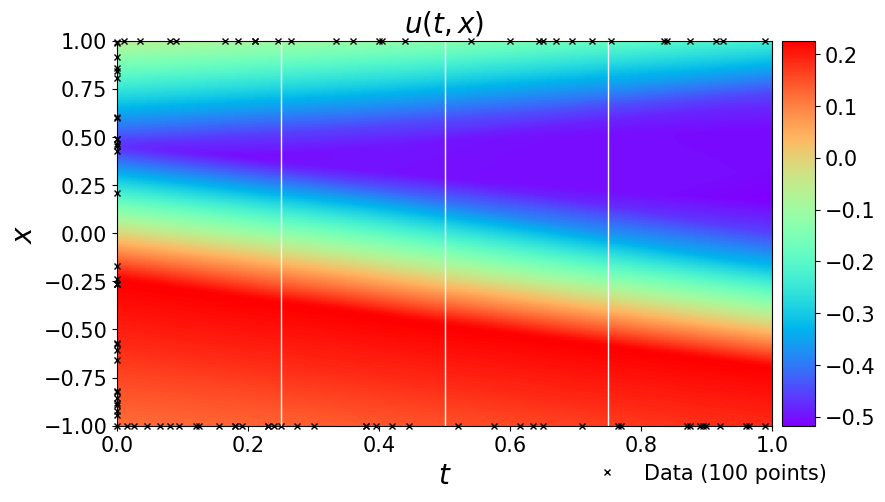

In [19]:
# Visually assess the prediction on the  $(x,t)$ plane

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

u_pred, f_pred = model.predict(x_star, t_star)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method="cubic")

h = ax.imshow(
    U_pred.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train.cpu(),
    x_train.cpu(),
    "kx",
    label="Data (%d points)" % (u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[50] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(t[100] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(t[150] * np.ones((2, 1)), line, "w-", linewidth=1)

ax.set_xlabel("$t$", size=20)
ax.set_ylabel("$x$", size=20)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={"size": 15},
)
ax.set_title("$u(t,x)$", fontsize=20)  # font size doubled
ax.tick_params(labelsize=15)

plt.show()

Error u: 9.673455e-01


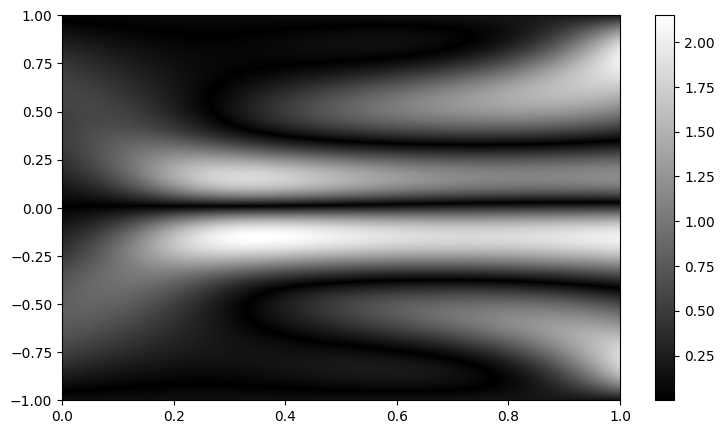

In [20]:
# Compute the mean prediction error
error_u = np.linalg.norm(u_star - u_pred.flatten(), 2) / np.linalg.norm(u_star, 2)
print("Error u: %e" % (error_u))

# U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

# Error in the $(x,t)$ planefig = plt.figure(figsize=(9, 5))
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(Error.T, extent=extent, origin="lower", aspect="auto", cmap="gray")
cbar = fig.colorbar(h)
plt.show()

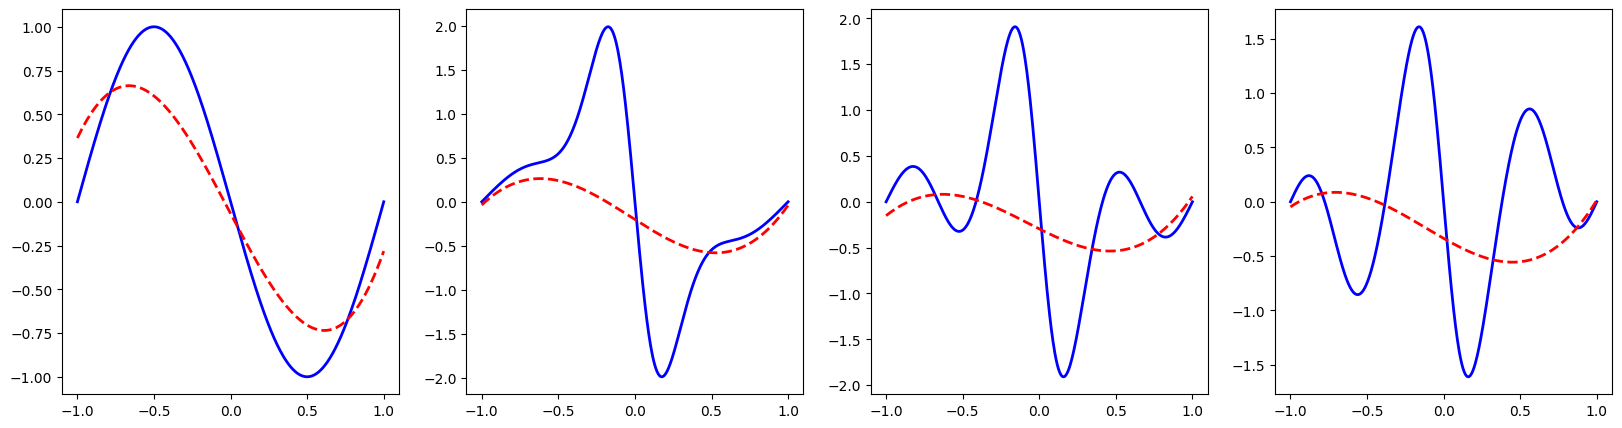

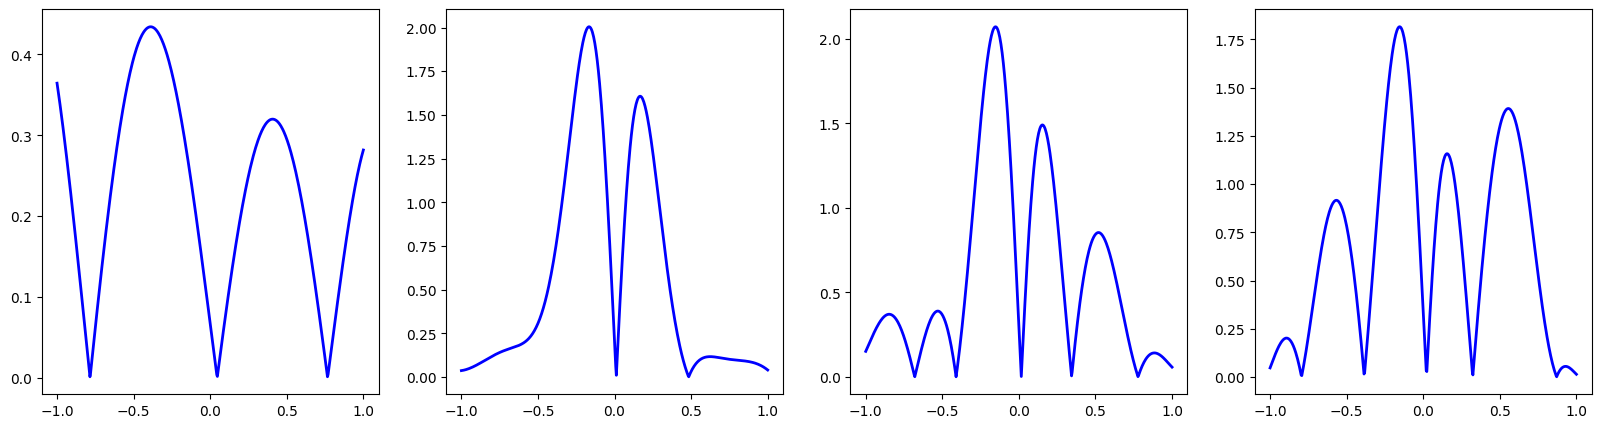

In [36]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Exact[0, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[0, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(142)
ax.plot(x, Exact[50, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[50, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(143)
ax.plot(x, Exact[100, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[100, :], "r--", linewidth=2, label="Prediction")


ax = fig.add_subplot(144)
ax.plot(x, Exact[150, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[150, :], "r--", linewidth=2, label="Prediction")

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Error[0, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(142)
ax.plot(x, Error[50, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(143)
ax.plot(x, Error[100, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(144)
ax.plot(x, Error[150, :], "b-", linewidth=2, label="Erreur")

# Trying to learn the hyperparameters $\alpha$ and $\beta$ and the solution $u(x,t)$

# New General Equation 
# $$ u_t + u u_x + \mu u_{xxx} + \nu (u_{xx} + u_{xxxx}) = 0$$

In [44]:
# Identification de paramètres physiques
np.random.seed(1234)
N_u = 500  # Number of points to compute the prediction loss (MSE_u)


# À compléter...
x_train_uf = torch.zeros(N_u)
t_train_uf = torch.zeros(N_u)
u_train_uf = torch.zeros(N_u)

index = torch.randint(x.size(0) * t.size(0), size=(N_u,))
ncols = t.size(0)
for i in range(N_u):
    idx_t = index[i] % ncols
    idx_x = index[i] // ncols
    x_train_uf[i] = x[idx_x]
    t_train_uf[i] = t[idx_t]
    u_train_uf[i] = Exact[idx_t, idx_x]

x_train_uf = x_train_uf.unsqueeze(-1).to(device)
t_train_uf = t_train_uf.unsqueeze(-1).to(device)
u_train_uf.to(device)

assert x_train_uf.shape == (N_u, 1), f"{x_train_uf.shape}"
assert t_train_uf.shape == (N_u, 1), f"{t_train_uf.shape}"
assert u_train_uf.shape == (N_u,), f"{u_train_uf.shape} vs {N_u}"

x_train_uf, t_train_uf, u_train_uf = prepare(x_train_uf, t_train_uf, u_train_uf)

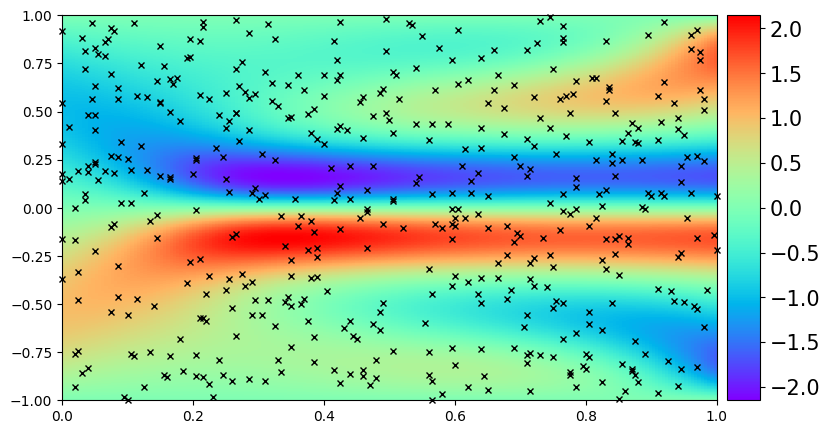

In [45]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Exact.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=extent,
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train_uf.cpu().detach(),
    x_train_uf.cpu().detach(),
    "kx",
    label="Data (%d points)" % (u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

plt.show()

In [46]:
class PhysicsInformedNN_ID(nn.Module):
    def __init__(self, dnn: DNN):
        super().__init__()

        # alpha = MU
        # beta = NU
        self.alpha = nn.Parameter(torch.randn(1))
        self.beta = nn.Parameter(torch.randn(1))

        self.dnn = dnn

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x.requires_grad_(True)
        t.requires_grad_(True)

        f_theta = self.dnn(x, t)

        df_dx = torch.autograd.grad(
            f_theta,
            x,
            grad_outputs=torch.ones_like(f_theta),
            retain_graph=True,
            create_graph=True,
        )[0]

        df2_dx2 = torch.autograd.grad(
            df_dx,
            x,
            grad_outputs=torch.ones_like(df_dx),
            retain_graph=True,
            create_graph=True,
        )[0]

        df3_dx3 = torch.autograd.grad(
            df2_dx2,
            x,
            grad_outputs=torch.ones_like(df2_dx2),
            retain_graph=True,
            create_graph=True,
        )[0]

        df4_dx4 = torch.autograd.grad(
            df3_dx3,
            x,
            grad_outputs=torch.ones_like(df3_dx3),
            retain_graph=True,
            create_graph=True,
        )[0]

        df_dt = torch.autograd.grad(
            f_theta,
            t,
            grad_outputs=torch.ones_like(f_theta),
            retain_graph=True,
            create_graph=True,
        )[0]

        h = (
            df_dt
            + f_theta * df_dx
            + self.alpha * df3_dx3
            + self.beta * (df2_dx2 + df4_dx4)
        )

        return f_theta, h

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u, f = self(x, t)
            u = u.detach().cpu().numpy()
            f = f.detach().cpu().numpy()
            return u, f

    def get_alpha(self):
        return self.alpha.item()

    def get_beta(self):
        return self.beta.item()


dnn = DNN().to(device)
model_id = PhysicsInformedNN_ID(dnn).to(device)

In [52]:
# À compléter...
dnn = DNN()
dnn.to(device)
model = PhysicsInformedNN_ID(dnn)
model.to(device)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-2)
optimizer = torch.optim.LBFGS(
    params=model.parameters(),
    lr=0.15,
    max_iter=500,
    max_eval=500,
    history_size=50,
    line_search_fn="strong_wolfe",
)

# print(optimizer.params)
epoch = 200
a_res = torch.zeros((epoch,))
nu_res = torch.zeros((epoch,))
ti = tqdm(range(epoch))
for i in ti:

    def loss_closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()

        u_pred, f_pred = model(x_train_uf, t_train_uf)
        loss, loss_u, loss_f = pinns_loss(
            u_pred, u_train_uf.unsqueeze(1), f_pred)
        # print(u_pred.shape, u_train_uf.shape, f_pred.shape)
        ti.set_description(
            f"loss: {loss}, nu: {float(model.get_alpha())}, a: {float(model.get_beta())}"
        )

        if loss.requires_grad:
            loss.backward()

        return loss

    optimizer.step(loss_closure)
    a_res[i] = model.get_alpha()
    nu_res[i] = model.get_beta()

loss: 0.563105046749115, nu: -0.355768620967865, a: 1.0590873956680298: 100%|██████████| 200/200 [02:49<00:00,  1.18it/s]    


In [53]:
print(a_res, nu_res)

tensor([ 1.3944,  0.1763, -0.2666, -0.3565, -0.3558, -0.3558, -0.3558, -0.3558,
        -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558,
        -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558,
        -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558,
        -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558,
        -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558,
        -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558,
        -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558,
        -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558,
        -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558,
        -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558,
        -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558, -0.3558,
        -0.3558, -0.3558, -0.3558, -0.35

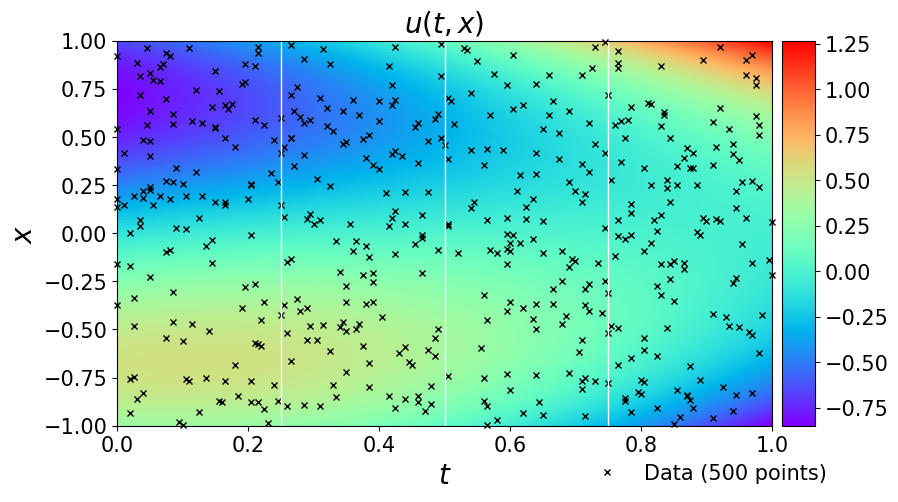

In [54]:
# Visually assess the prediction on the  $(x,t)$ plane

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

u_pred, f_pred = model.predict(x_star, t_star)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method="cubic")

h = ax.imshow(
    U_pred.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train_uf.detach().cpu(),
    x_train_uf.detach().cpu(),
    "kx",
    label="Data (%d points)" % (u_train_uf.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[50] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(t[100] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(t[150] * np.ones((2, 1)), line, "w-", linewidth=1)

ax.set_xlabel("$t$", size=20)
ax.set_ylabel("$x$", size=20)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={"size": 15},
)
ax.set_title("$u(t,x)$", fontsize=20)  # font size doubled
ax.tick_params(labelsize=15)

plt.show()

Error u: 8.750403e-01
Error u: 2.207617e+00


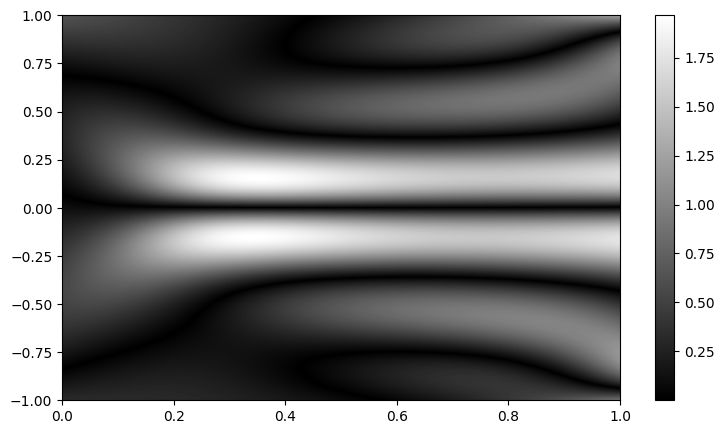

In [55]:
# FORECAST QUALITY
u_pred, f_pred = model.predict(x_star, t_star)
u_pred = u_pred.flatten()

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print("Error u: %e" % (error_u))

U_pred = griddata(X_star, u_pred, (X, T), method="cubic")
Error = np.abs(Exact - U_pred)
error_u2 = np.linalg.norm(Exact - U_pred, "fro") / np.linalg.norm(U_pred, "fro")
print("Error u: %e" % (error_u2))

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Error.cpu().T,
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
    cmap="gray",
)
cbar = fig.colorbar(h)
plt.show()

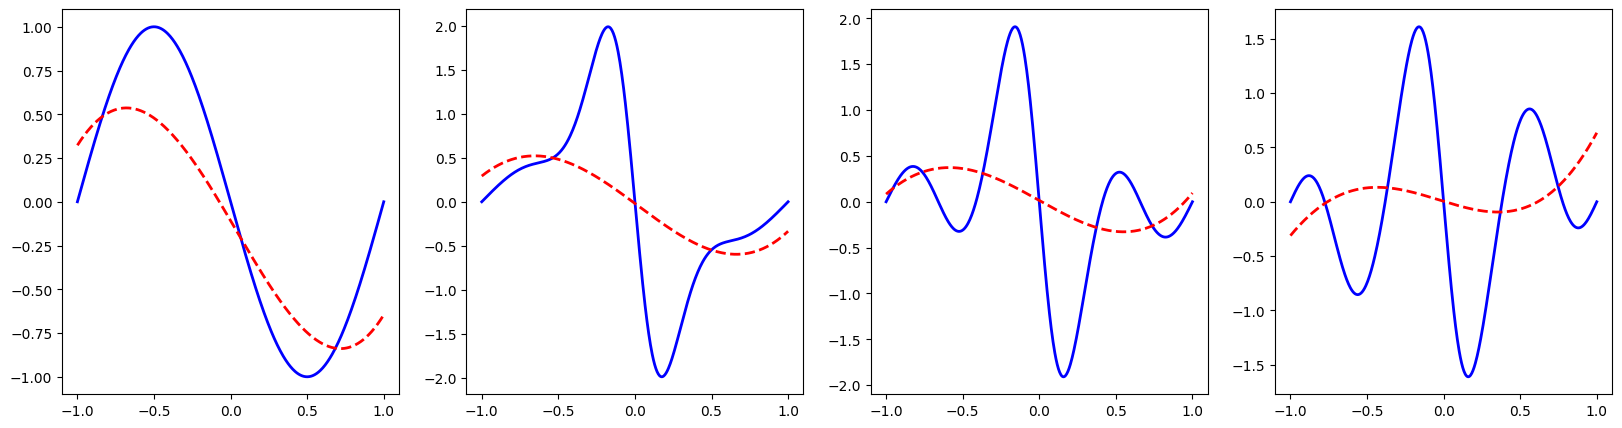

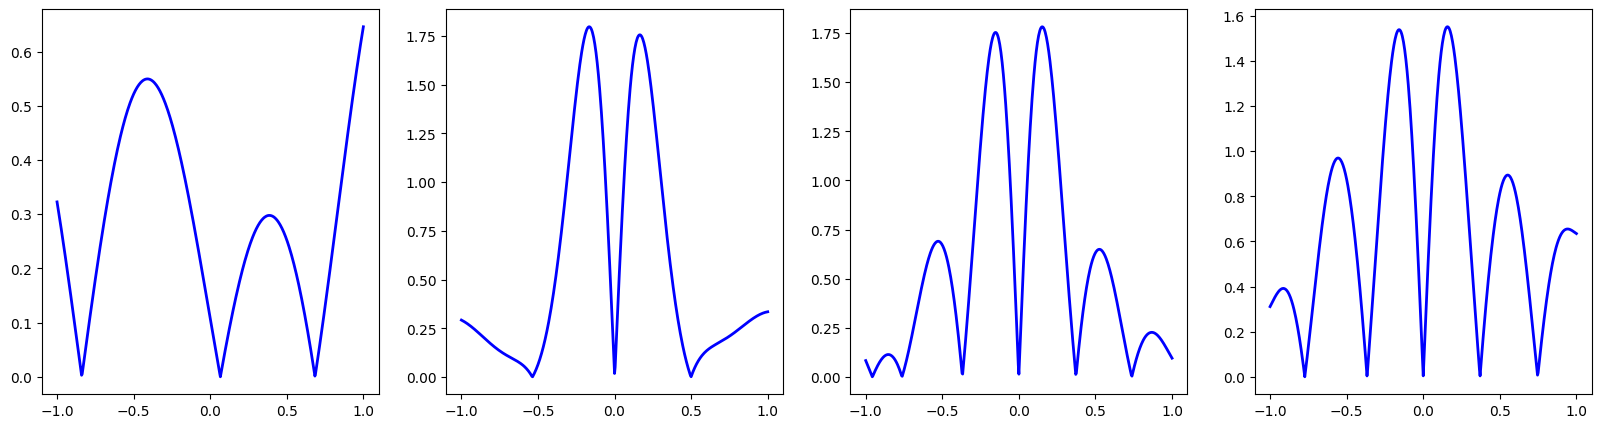

In [56]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Exact[0, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[0, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(142)
ax.plot(x, Exact[50, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[50, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(143)
ax.plot(x, Exact[100, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[100, :], "r--", linewidth=2, label="Prediction")


ax = fig.add_subplot(144)
ax.plot(x, Exact[150, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[150, :], "r--", linewidth=2, label="Prediction")

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Error[0, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(142)
ax.plot(x, Error[50, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(143)
ax.plot(x, Error[100, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(144)
ax.plot(x, Error[150, :], "b-", linewidth=2, label="Erreur")